In [1]:
# wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=14UBHX6GTW_4YiyjNJB3EEq7Xb83AjuaK' -O process_mining_datasets.zip

import pandas as pd
# pd.set_option("max_columns", 200)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gzip

%load_ext autoreload
%autoreload 2

# Meus pacotes
from pm_tools import parse_mxml as pm
from pm_tools import log_representation as lr
from pm_tools import plots as plts
from pm_tools import model_utils as mu
from pm_tools import drift_detection as dd
from pm_tools import offline_streaming_clustering as off_sc

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 
import traceback 

from copy import deepcopy
import random
random.seed(42)
import os
import re
import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.cluster import KMeans, AgglomerativeClustering

import gc
gc.enable()

# # # # # # # # # # #
# LOAN APPLICATIONS #
# # # # # # # # # # #
# aliases = {
#     'Loan__application_received': 'Loan__application_received',
#     'Appraise_property': 'Appraise_property',
#     'Approve_application': 'Approve_application',
#     'Assess_eligibility': 'Assess_eligibility',
#     'Assess_loan_risk': 'Assess_loan_risk',
#     'Cancel_application': 'Cancel_application',
#     'Check__application__form_completeness': 'Check__application__form_completeness',
#     'Check_credit_history': 'Check_credit_history',
#     'Check_if_home_insurance_quote_is_requested': 'Check_if_home_insurance_quote_is_requested',
#     'Prepare_acceptance_pack': 'Prepare_acceptance_pack',
#     'Receive_updated_application': 'Receive_updated_application',
#     'Reject_application': 'Reject_application',
#     'Return_application_back_to_applicant': 'Return_application_back_to_applicant',
#     'Send_acceptance_pack': 'Send_acceptance_pack',
#     'Send_home_insurance_quote': 'Send_home_insurance_quote',
#     'Verify_repayment_agreement': 'Verify_repayment_agreement',
#     'Loan__application_approved': 'Loan__application_approved',
#     'Loan_application_rejected': 'Loan_application_rejected',
#     'Loan__application_canceled': 'Loan__application_canceled',
# }

aliases = {
    'Loan__application_received': 'START',
    'Appraise_property': 'A',
    'Approve_application': 'B',
    'Assess_eligibility': 'C',
    'Assess_loan_risk': 'D',
    'Cancel_application': 'E',
    'Check__application__form_completeness': 'F',
    'Check_credit_history': 'G',
    'Check_if_home_insurance_quote_is_requested': 'H',
    'Prepare_acceptance_pack': 'I',
    'Receive_updated_application': 'J',
    'Reject_application': 'K',
    'Return_application_back_to_applicant': 'L',
    'Send_acceptance_pack': 'M',
    'Send_home_insurance_quote': 'N',
    'Verify_repayment_agreement': 'O',
    'Loan__application_approved': 'END_A',
    'Loan_application_rejected': 'END_R',
    'Loan__application_canceled': 'END_C',
}

inv_aliases = {v: k for k, v in aliases.items()}

In [2]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

In [3]:
logs = insensitive_glob("process_mining_datasets/*/*k.MXML")

In [4]:
logs = [x for x in logs if "2.5" not in x]

### Pipeline Streaming Clustering

In [5]:
logs[20].split("\\")[2][0:-5]

'IOR7.5k'

In [6]:
logs[25].split("\\")[2][4:-5]

'lp5k'

In [41]:
def run_pipeline(args):
    try:
        r = {}
        
        # Tratamento do caminho do arquivo para estruturar nomes
        # e tamanho do log
        split = args["log"].split("\\")

        cd_name = split[1]
        log_name = split[2][:-5]

        log_size = log_name.replace(cd_name, "").replace("new_", "")
        try:
            log_size = int(float(log_size.replace("k", "")) * 1000)
            # Monta o vetor de resposta
            y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]
        except:
            log_size = 3000
            y_true = [890, 1890]
        

        # String para identificação da memória cache
        cached_info = "_".join([
            log_name.replace("new_", ""), str(log_size), args["model"], args["representation"], str(args["window_size"]), str(args["sliding_window"])
        ])

        print(cached_info, end="\r")
        
        # Lê o log e aplica a representação
        try:
            log_read = pm.all_prep(gzip.open(args["log"]), aliases)
        except OSError:
            log_read = pm.all_prep(args["log"], aliases)
            
        df = objects["representation"][args["representation"]](
            log_read
        )


        run_df, measures_df = off_sc.run_offline_clustering_window(
            sk_clone(objects["model"][args["model"]]),
            args["window_size"],
            df,
            args["sliding_window"],
            args['sliding_step'],
            args['reuse_centers']
        )

        all_metrics = run_df.join(measures_df)
        
        all_metrics.to_csv("C:/Users/rafae/OneDrive/Documentos/best_clusterings_2020-06-07/" + cached_info + ".csv")
        
        # test = pd.read_csv("../offline_window_clustering_results/" + cached_info + ".csv", index_col=0)
        # assert test.shape == all_metrics.shape
        
        return all_metrics

    except Exception as e:
        traceback.print_exc()

In [22]:
# min_dist_between_centroids_frequency_4_False_2_50_kmeans__k=8_tradicional_-1

In [23]:
logs_5k = [x for x in logs if "7" not in x and "5k" in x] 
logs_7k = [x for x in logs if "7" in x] 
logs_10k = [x for x in logs if "10" in x] 

In [24]:
from sklearn.cluster import SpectralClustering, OPTICS, DBSCAN

In [60]:
objects = {
    "model": {
        "kmeans__k=12": KMeans(n_clusters=12, random_state=42, n_jobs=3),
        "kmeans__k=8": KMeans(n_clusters=8, random_state=42, n_jobs=3),
        "kmeans__k=6": KMeans(n_clusters=6, random_state=42, n_jobs=3),
        "kmeans__k=3": KMeans(n_clusters=3, random_state=42, n_jobs=3),
        "kmeans__k=2": KMeans(n_clusters=2, random_state=42, n_jobs=3),
        "agglomerative__k=12_linkage=ward": AgglomerativeClustering(n_clusters=12, linkage='ward'),
        "agglomerative__k=8_linkage=ward": AgglomerativeClustering(n_clusters=8, linkage='ward'),
        "agglomerative__k=6_linkage=ward": AgglomerativeClustering(n_clusters=6, linkage='ward'),
        "agglomerative__k=3_linkage=ward": AgglomerativeClustering(n_clusters=3, linkage='ward'),
        "agglomerative__k=2_linkage=ward": AgglomerativeClustering(n_clusters=2, linkage='ward'),
        "agglomerative__k=2_affinity=jaccard_linkage=complete": AgglomerativeClustering(affinity='jaccard', n_clusters=2, linkage='complete'),
        "agglomerative__k=3_affinity=jaccard_linkage=complete": AgglomerativeClustering(affinity='jaccard', n_clusters=3, linkage='complete'),
        "agglomerative__k=6_affinity=jaccard_linkage=complete": AgglomerativeClustering(affinity='jaccard', n_clusters=6, linkage='complete'),
        "agglomerative__k=8_affinity=jaccard_linkage=complete": AgglomerativeClustering(affinity='jaccard', n_clusters=8, linkage='complete'),
        "spectral__k=3": SpectralClustering(n_clusters=3, random_state=42),
        "spectral__k=6": SpectralClustering(n_clusters=6, random_state=42),
        "spectral__k=8": SpectralClustering(n_clusters=8, random_state=42),
        "dbscan__eps=0.5_min_samples=10": DBSCAN(eps=0.5, min_samples=10),
        "dbscan__eps=1.5_min_samples=10": DBSCAN(eps=2.1, min_samples=2),
        "dbscan__eps=2_min_samples=10": DBSCAN(eps=2., min_samples=10),
        "optics__min_samples=10_max_eps=10": OPTICS(min_samples=25, max_eps=4),
        "optics__min_samples=10_max_eps=10_metric=jaccard": OPTICS(min_samples=20, max_eps=2.5, xi=0.1, metric="jaccard"),      
        
    },
    
    "representation": {
        "binary": lambda x: lr.get_binary_representation(lr.get_traces_as_tokens(x)),
        "frequency": lambda x: lr.get_frequency_representation(lr.get_traces_as_tokens(x)),
        "tfidf": lambda x: lr.get_tfidf_representation(lr.get_traces_as_tokens(x)),
        "transitions": lambda x: lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)),
        "positions": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x)),
        "positions_min_max": lambda x: lr.get_min_max_positions_representation(lr.get_traces_as_tokens(x)),
        "positions_avg": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x), include_cols=["_avg"]),
        "activities_order_normalized": lambda x: lr.get_activities_order_representation(lr.get_traces_as_tokens(x)),
        "activities_pair_distance_normalized": lambda x: lr.get_activities_pair_distance_representation(lr.get_traces_as_tokens(x)),
    }
}

In [26]:
binary_support = ["cf", "cb", "cm", "rp", "pm", "fr", 're']
frequency_support = ["cf", "cb", 'cp', "cm", "rp", "pm", "fr", 're', 'lp']
binary_not_support = ["pl", "cd", "cp", "sw", 'lp']
hardest = ["rp", "fr", "sw"]
easyest = ["cf", "cb", "cm", "pl", "cd", "cp", "sw"]
all_ = frequency_support + binary_not_support

In [68]:
logs_5k[5]

'process_mining_datasets\\fr\\fr5k.MXML'

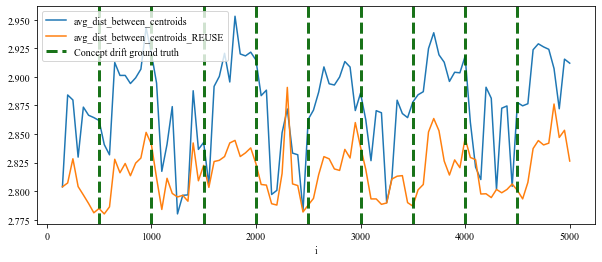

In [81]:
win_size = 150
log_ = logs_5k[5]

all_metrics_kmeans = run_pipeline({
    "log": log_,
    "representation": "transitions",
    "sliding_window": True,
    "sliding_step": 50,
    "window_size": win_size,
    "model": 'kmeans__k=6',
    'reuse_centers': False
})

all_metrics_kmeans_reuse = run_pipeline({
    "log": log_,
    "representation": "transitions",
    "sliding_window": True,
    "sliding_step": 50,
    "window_size": win_size,
    "model": 'kmeans__k=6',
    'reuse_centers': True
})

all_metrics_kmeans.index += win_size
all_metrics_kmeans_reuse.index += win_size

all_metrics_kmeans["avg_dist_between_centroids"].plot(figsize=(10, 4))
all_metrics_kmeans_reuse.add_suffix('_REUSE')["avg_dist_between_centroids_REUSE"].plot(figsize=(10, 4))

plts.plot_drift_vertical_lines(5000)
plt.legend()

In [82]:
all_metrics_kmeans_reuse.columns

Index(['k', 'Silhouette', 'DBi', 'centroids', 'sum_dist_between_centroids',
       'avg_dist_between_centroids', 'std_dist_between_centroids',
       'min_dist_between_centroids', 'max_dist_between_centroids',
       'amplitude_dist_between_centroids', 'squared_sum', 'sum_squared_sum',
       'avg_dist_between_sq_sums', 'std_dist_between_sq_sums', 'volume_list',
       'radius_list', 'dist_intra_cluster_list', 'skewness_list',
       'cluster_std_list', 'avg_radius', 'std_radius',
       'avg_dist_intra_cluster', 'std_dist_intra_cluster', 'avg_skewness',
       'std_skewness', 'avg_cluster_std', 'std_cluster_std', 'squared_sum_i=0',
       'squared_sum_i=1', 'squared_sum_i=2', 'squared_sum_i=3',
       'squared_sum_i=4', 'squared_sum_i=5', 'avg_squared_sum',
       'std_squared_sum', 'diff_k', 'diff_Silhouette', 'diff_DBi',
       'diff_centroids', 'std_diff_centroids', 'total_MSE', 'avg_MSE',
       'count_non_zero_MSE', 'diff_sum_dist_between_centroids',
       'diff_avg_dist_between

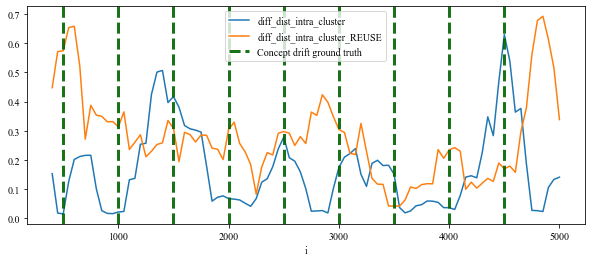

In [106]:
rwin = 5
all_metrics_kmeans["diff_dist_intra_cluster"].rolling(rwin).mean().plot(figsize=(10, 4))
all_metrics_kmeans_reuse.add_suffix('_REUSE')["diff_dist_intra_cluster" + "_REUSE"].rolling(rwin).mean().plot(figsize=(10, 4))

plts.plot_drift_vertical_lines(5000)
plt.legend()

In [ ]:
cluster_results = {}

for log_ in tqdm(logs_10k + logs_5k):
# for log_ in tqdm(logs_5k):
    split = log_.split("\\")

    cd_name = split[1]
    log_name = split[2][:-5]
    
    if "R" in cd_name and "I" in cd_name: 
        continue

    log_size = log_name.replace(cd_name, "").replace("new_", "")
    log_size = int(float(log_size.replace("k", "")) * 1000)
    
    key = cd_name + "__" + str(log_size)

    cluster_results[key] = run_pipeline({
        "log": log_,
        "representation": "binary",
        "sliding_window": False,
        "window_size": 100,
        "model": 'kmeans__k=2'
    })

    cluster_results[key].index += cluster_results[key].index[1]

In [26]:
features_df = pd.DataFrame()
col = ['avg_dist_between_centroids']

for key in cluster_results:
    features_df[key.split("__")[0]] = cluster_results[key][col].values.reshape(1,-1)[0]
    
features_df.index = cluster_results[key].index

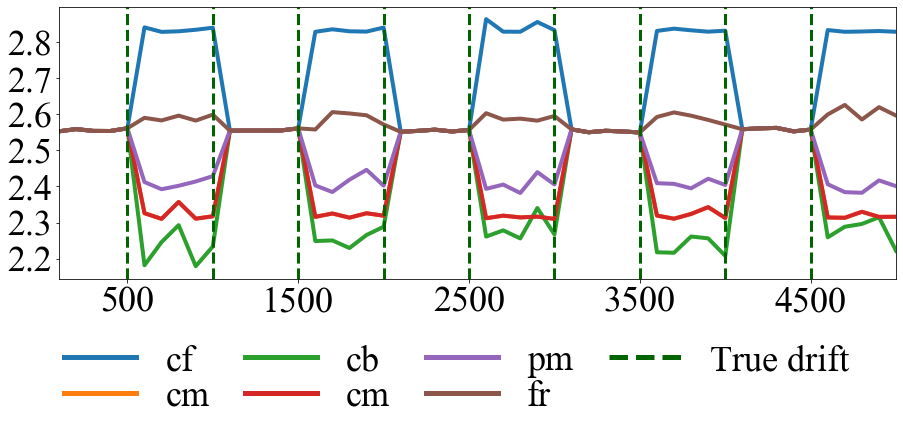

In [27]:
features_df[['cf', 'cm', 'cb', 'cm', 'pm', 'fr']].plot(figsize=(15,5), lw=4)

plt.rcParams["font.family"] = "Times New Roman"
ax = plt.gca()

plts.plot_drift_vertical_lines(5000, resp_drift=None, label="True drift")

for item in ([ax.title, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(36)

# ax.set_xlabel('índice dos $\it{traces}$')
ax.set_xlabel(None)
ax.xaxis.label.set_fontsize(20)
# ax.set_xlim((0, df.index.max() + 100))
# bbox_to_anchor=(0.5, 1.3),
# bbox_to_anchor=(0.475, -0.12)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.475, -0.12),
          fancybox=False, shadow=True, prop={"family":"Times New Roman", "size":"36"},
          frameon=False, ncol=4, labelspacing=0.05, columnspacing=1)

for line in leg.get_lines():
    line.set_linewidth(5)

plt.xticks(np.arange(500, 5000, 1000));
#plt.yticks(np.arange(2.2, 2.9, .2));

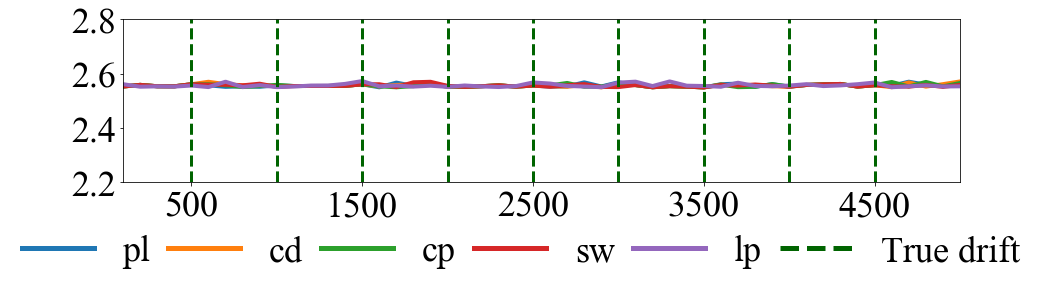

In [28]:
features_df[binary_not_support].plot(figsize=(15,3), lw=4)

plt.rcParams["font.family"] = "Times New Roman"
ax = plt.gca()

plts.plot_drift_vertical_lines(5000, resp_drift=None, label="True drift")

for item in ([ax.title, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(36)

# ax.set_xlabel('índice dos $\it{traces}$')
ax.set_xlabel(None)
ax.xaxis.label.set_fontsize(20)
# ax.set_xlim((0, df.index.max() + 100))
# bbox_to_anchor=(0.5, 1.3),
# bbox_to_anchor=(0.475, -0.12)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.475, -0.12),
          fancybox=False, shadow=True, prop={"family":"Times New Roman", "size":"36"},
          frameon=False, ncol=6, labelspacing=0, columnspacing=0.5)

for line in leg.get_lines():
    line.set_linewidth(5)

plt.xticks(np.arange(500, 5000, 1000));
plt.yticks(np.arange(2.2, 2.9, .2));

### Transitions

In [39]:
cluster_results_transitions = {}

for log_ in tqdm(logs_10k + logs_5k):
# for log_ in tqdm(logs_5k):
    split = log_.split("\\")

    cd_name = split[1]
    log_name = split[2][:-5]
    
    if "R" in cd_name and "I" in cd_name: 
        continue

    log_size = log_name.replace(cd_name, "").replace("new_", "")
    log_size = int(float(log_size.replace("k", "")) * 1000)
    
    key = cd_name + "__" + str(log_size)

    cluster_results_transitions[key] = run_pipeline({
        "log": log_,
        "representation": "binary",
        "sliding_window": False,
        "window_size": 100,
        "model": 'kmeans__k=2'
    })
    
    if cluster_results[key].index[0] == 0:
        cluster_results_transitions[key].index += cluster_results[key].index[1]

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

  0%|                                                                                           | 0/54 [00:09<?, ?it/s]


KeyError: 'cb__10000'

In [30]:
features_df_transitions = pd.DataFrame()
col = ['avg_dist_between_centroids']

for key in cluster_results_transitions:
    features_df_transitions[key.split("__")[0]] = cluster_results_transitions[key][col].values.reshape(1,-1)[0]
    
features_df_transitions.index = cluster_results_transitions[key].index

In [31]:
if features_df_transitions.index[0] == 0:
    features_df_transitions.index += features_df_transitions.index[1]

In [32]:
resp = list(range(500, 5000, 500))

In [33]:
features_df_transitions.loc[100:500]['lp'] = features_df_transitions.loc[100:500]['cp']
features_df_transitions.loc[1100:1500]['lp'] = features_df_transitions.loc[1000:1500]['cp']
features_df_transitions.loc[2100:2500]['lp'] = features_df_transitions.loc[2000:2500]['cp']
features_df_transitions.loc[3100:3500]['lp'] = features_df_transitions.loc[3000:3500]['cp']
features_df_transitions.loc[4100:4500]['lp'] = features_df_transitions.loc[4000:4500]['cp']

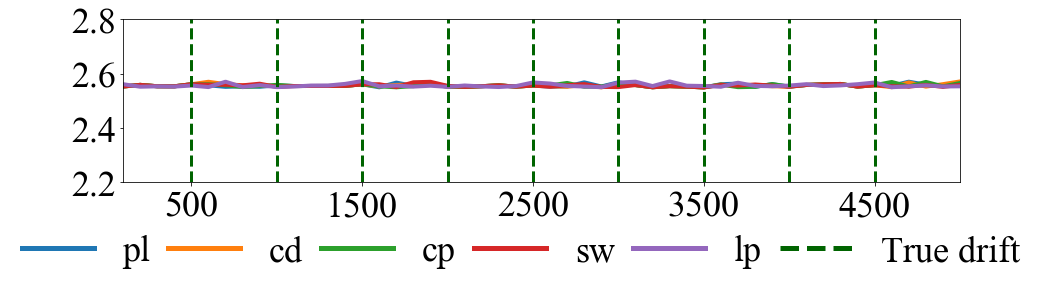

In [34]:
features_df_transitions[binary_not_support].plot(figsize=(15,3), lw=4)

plt.rcParams["font.family"] = "Times New Roman"
ax = plt.gca()

plts.plot_drift_vertical_lines(5000, resp_drift=None, label="True drift")

for item in ([ax.title, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(36)

# ax.set_xlabel('índice dos $\it{traces}$')
ax.set_xlabel(None)
ax.xaxis.label.set_fontsize(20)
# ax.set_xlim((0, df.index.max() + 100))
# bbox_to_anchor=(0.5, 1.3),
# bbox_to_anchor=(0.475, -0.12)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.475, -0.12),
          fancybox=False, shadow=True, prop={"family":"Times New Roman", "size":"36"},
          frameon=False, ncol=6, labelspacing=0, columnspacing=0.5)

for line in leg.get_lines():
    line.set_linewidth(5)

plt.xticks(np.arange(500, 5000, 1000));
plt.yticks(np.arange(2.2, 2.9, .2));

### RE example

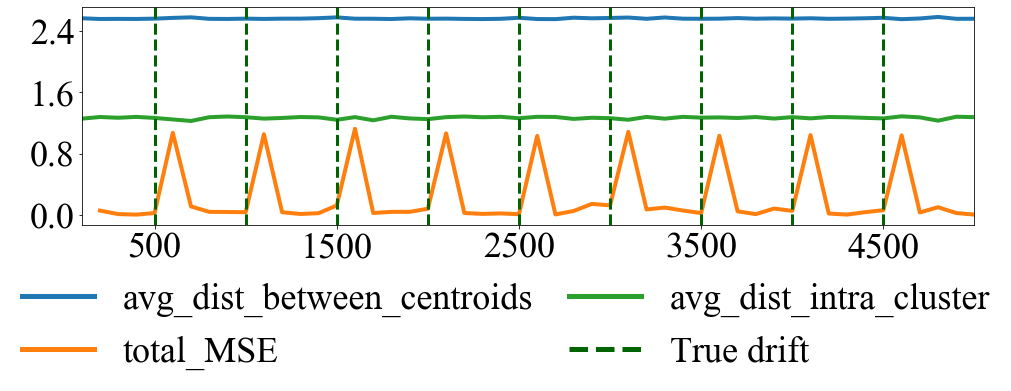

In [270]:
cluster_results["re__5000"][["avg_dist_between_centroids", 'total_MSE', 'avg_dist_intra_cluster']].plot(figsize=(16,4), lw=4)

plt.rcParams["font.family"] = "Times New Roman"
ax = plt.gca()

plts.plot_drift_vertical_lines(5000, resp_drift=None, label="True drift")

for item in ([ax.title, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(36)

# ax.set_xlabel('índice dos $\it{traces}$')
ax.set_xlabel(None)
ax.xaxis.label.set_fontsize(20)
# ax.set_xlim((0, df.index.max() + 100))
# bbox_to_anchor=(0.5, 1.3),
# bbox_to_anchor=(0.475, -0.12)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.475, -0.12),
          fancybox=False, shadow=True, prop={"family":"Times New Roman", "size":"36"},
          frameon=False, ncol=2, labelspacing=0.5, columnspacing=1)

for line in leg.get_lines():
    line.set_linewidth(5)

plt.xticks(np.arange(500, 5000, 1000));
plt.yticks(np.arange(0, 2.6, 0.8));

### Drift Detection Pipeline

In [150]:
def drift_detect_pipeline(args, all_metrics):
    to_string = [args["detection_type"], str(args["rolling_window"]), str(args["std_tolerance"]).replace(".", "-")]
    if "smooth_factor" in args:
        to_string += [str(args["smooth_factor"]).replace(".", "-")]
    
    # Monta o vetor de resposta
    if args['log_size'] == 3000:
        y_true = [890, 1890]
    else:
        y_true = [x for x in range(int(args["log_size"]/10), args["log_size"], int(args["log_size"]/10))]
    
    if "cols" in args:
        cols = args["cols"]
    else:
        cols = all_metrics.select_dtypes(include=np.number).columns
    
    results = []
    for col in cols:
        if (col not in ["k"] and not col.startswith("diff") ) or col in ["diff_centroids"]:
            r = deepcopy(args)
            r["measure"] = col

            # print(col)
            # print(all_metrics[col].dtype)

            if args["detection_type"] == "tradicional":
                detected_drifts, extra = dd.detect_concept_drift(
                    all_metrics, 
                    col,
                    args["rolling_window"],
                    args["std_tolerance"],
                    args["min_tol"]
                )

            if args["detection_type"] == "cumulative":
                detected_drifts, extra = dd.cumulative_detect_concept_drift(
                    all_metrics, 
                    col,
                    args["rolling_window"],
                    args["std_tolerance"]
                )


            if args["detection_type"] == "exponential":
                detected_drifts, extra = dd.exponential_smooth_detect_concept_drift(
                    all_metrics,
                    col,
                    args["rolling_window"],
                    args["std_tolerance"],
                    args["smooth_factor"]
                )
            
            if args["detection_type"] == "mean":
                detected_drifts, extra = dd.detect_concept_drift_rolling_mean(
                    all_metrics,
                    col,
                    args["rolling_window"],
                    args["std_tolerance"],
                    args["min_tol"]
                )
                
            if args["detection_type"] == "value":
                detected_drifts, extra = dd.detect_concept_drift_value(
                    all_metrics,
                    col,
                    args["rolling_window"],
                    args["std_tolerance"]
                )

            metrics_results = dd.get_metrics(
                detected_drifts,
                y_true,
                args["window_size"]
            )

            r["extra"] = extra
            r.update(args)
            r.update(metrics_results)

            results.append(r)

            gc.collect()
    
    return pd.DataFrame(results)

In [36]:
base_path_detection = "C:/Users/rafae/OneDrive/Documentos/best_clusterings_2020-06-07/"

In [114]:
detection_results = pd.DataFrame()

for change_pattern in ['fr']:
    for log_size in [5000, 10000]:
        args = {
            "detection_type": 'tradicional', # "mean", #, "cumulative"],
            "representation": "binary",
            "model": "kmeans__k=2",
            "tipo_mudanca": change_pattern,
            "log_size": log_size,
            "window_size": 100,
            "rolling_window": 3,
            "min_tol": 0.008,
            "std_tolerance": 2.5,
            "cols": ["avg_dist_between_centroids"],
            #"smooth_factor": 0.7
        }
        
        log_suffix = '5k' if log_size == 5000 else '7.5k' if log_size == 7500 else '10k'        
        all_metrics = pd.read_csv(base_path_detection + "_".join([
            change_pattern + log_suffix, 
            str(log_size),
            args["model"],
            args["representation"],
            str(args["window_size"]),
            "False" 
        ]) + ".csv", index_col=0)
        
        if all_metrics.index[0] == 0:
            all_metrics.index = all_metrics.index + all_metrics.index[1]
        
        results = drift_detect_pipeline(args, all_metrics)
        detection_results = pd.concat([
            detection_results, results
        ], ignore_index=True)

In [115]:
detection_results

,detection_type,representation,model,tipo_mudanca,log_size,window_size,rolling_window,min_tol,std_tolerance,cols,measure,extra,Precision,Recall,F1,Delay,Correct_Predictions,Support,Drifts_Found,Resp
0,tradicional,binary,kmeans__k=2,fr,5000,100,3,0.008,2.5,[avg_dist_between_centroids],avg_dist_between_centroids,"{'lowers': [nan, nan, nan, nan, 2.533467788151...",1.000000,1.0,1.0,100.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,"[600, 1100, 1700, 2100, 2600, 3100, 3600, 4000...","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
1,tradicional,binary,kmeans__k=2,fr,10000,100,3,0.008,2.5,[avg_dist_between_centroids],avg_dist_between_centroids,"{'lowers': [nan, nan, nan, nan, 2.535462110881...",0.818182,1.0,0.9,100.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,"[1100, 2100, 3100, 4100, 5100, 6100, 7100, 760...","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800..."


In [112]:
logs_10k[5]

'process_mining_datasets\\fr\\fr10k.MXML'

{'Precision': 0.8181818181818182, 'Recall': 1.0, 'F1': 0.8999999999999999, 'Delay': 100.0, 'Correct_Predictions': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'Support': 9, 'Drifts_Found': [1100, 2100, 3100, 4100, 5100, 6100, 7100, 7600, 8100, 9100, 9800], 'Resp': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]}


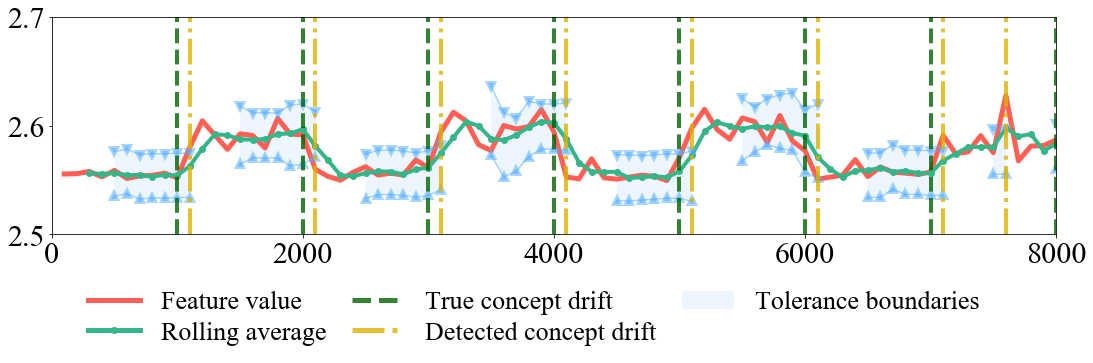

In [126]:
col = "avg_dist_between_centroids"

y_true = [x for x in range(int(args["log_size"]/10), args["log_size"], int(args["log_size"]/10))]
res = detection_results[(detection_results.measure == col) & (detection_results.log_size == args["log_size"])]

plts.plot_deteccao_drift(
    all_metrics_kmeans.rename(columns={col: "Feature value"}),
    'Feature value',
    [x for x in res.Drifts_Found.iloc[0]],
    y_true,
    res.extra.iloc[0]['means'],
    res.extra.iloc[0]['lowers'],
    res.extra.iloc[0]['uppers'],
    cluster_window_size=args['window_size'],
    save_png=""
)

plt.gca().set_xlim((0, 1000))
plt.xticks(np.arange(0, 10000, 2000));
plt.yticks(np.arange(2.5, 2.7, .1));

process_mining_datasets\fr\fr10k.MXMLlse
0.6954544457650691


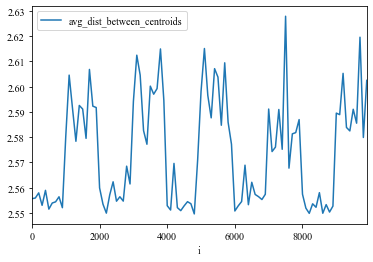

In [108]:
log_ = logs_10k[5]
args = {
    "log": log_,
    "log_size": 10000,
    "representation": "binary",
    "sliding_window": False,
    "window_size": 100,
    "model": 'kmeans__k=2'
    #"model": 'optics__min_samples=10_max_eps=10_metric=jaccard'
}
all_metrics_kmeans = run_pipeline(args)
print(log_)
print(all_metrics_kmeans.Silhouette.mean())

# all_metrics_agg["avg_dist_between_centroids"].plot()
all_metrics_kmeans["avg_dist_between_centroids"].plot()
all_metrics_kmeans.index += all_metrics_kmeans.index[1]
#all_metrics_kmeans["k"].add(1).plot()
# plts.plot_drift_vertical_lines(5000)
plt.legend()

In [227]:
all_metrics_kmeans.index = all_metrics_kmeans.index + 250

In [233]:
[x - 250 for x in res.Drifts_Found.iloc[0]]

[500, 1500, 2250, 3000, 4000]

In [127]:
founds = {}

for row in results[(results.measure.isin(['total_MSE', 'avg_MSE', 'count_non_zero_MSE']))].Drifts_Found.values:
    print(row)
    for drift in row:
        if drift in founds:
            founds[drift] += 1
        else:
            founds[drift] = 1

[2300]
[2300]
[600, 4600]


In [61]:
results.sort_values("F1", ascending=False).head()

,detection_type,tipo_mudanca,log_size,window_size,rolling_window,std_tolerance,measure,extra,Precision,Recall,F1,Delay,Correct_Predictions,Support,Drifts_Found,Resp
33,tradicional,cb,10000,100,5,2.25,DIM__Prepare_acceptance_pack_centroid_1,"{'lowers': [nan, nan, nan, nan, nan, nan, 1.0,...",0.8,0.888889,0.842105,100.0,"[1, 0, 1, 1, 1, 1, 1, 1, 1]",8,"[1000, 1700, 3000, 4000, 5000, 6000, 7000, 800...","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800..."
111,tradicional,cb,10000,100,5,2.25,MSE__Prepare_acceptance_pack,"{'lowers': [nan, nan, nan, nan, nan, nan, 0.0,...",0.8,0.888889,0.842105,100.0,"[1, 0, 1, 1, 1, 1, 1, 1, 1]",8,"[1000, 1700, 3000, 4000, 5000, 6000, 7000, 800...","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800..."
106,tradicional,cb,10000,100,5,2.25,MSE__Check_if_home_insurance_quote_is_requested,"{'lowers': [nan, nan, nan, nan, nan, nan, 0.0,...",0.8,0.888889,0.842105,100.0,"[1, 0, 1, 1, 1, 1, 1, 1, 1]",8,"[1000, 1700, 3000, 4000, 5000, 6000, 7000, 800...","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800..."
28,tradicional,cb,10000,100,5,2.25,DIM__Check_if_home_insurance_quote_is_requeste...,"{'lowers': [nan, nan, nan, nan, nan, nan, 1.0,...",0.8,0.888889,0.842105,100.0,"[1, 0, 1, 1, 1, 1, 1, 1, 1]",8,"[1000, 1700, 3000, 4000, 5000, 6000, 7000, 800...","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800..."
52,tradicional,cb,10000,100,5,2.25,DIM__Prepare_acceptance_pack_centroid_2,"{'lowers': [nan, nan, nan, nan, nan, nan, 1.0,...",0.7,0.777778,0.736842,100.0,"[1, 1, 1, 0, 1, 1, 1, 0, 1]",7,"[1000, 2000, 3000, 3900, 5000, 6000, 7000, 780...","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800..."


In [13]:
import matplotlib.pyplot as plt

In [18]:
log_ = logs_5k[0]
all_metrics_kmeans = run_pipeline({
    "log": log_,
    "representation": "binary",
    "sliding_window": False,
    "window_size": 100,
    "model": 'kmeans__k=2'
    #"model": 'optics__min_samples=10_max_eps=10_metric=jaccard'
})

all_metrics_kmeans.index = all_metrics_kmeans.index + all_metrics_kmeans.index[0]

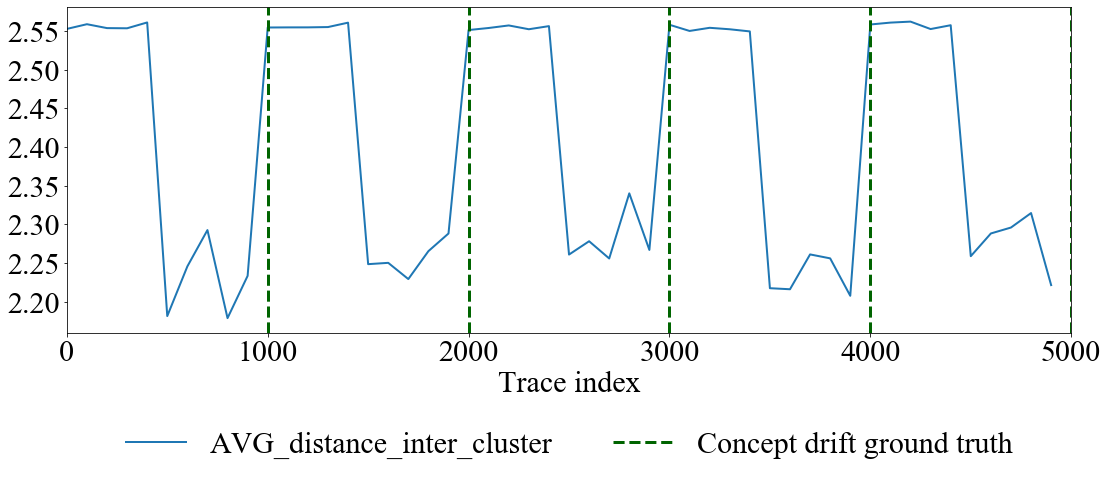

In [25]:
all_metrics_kmeans[[
    col for col in all_metrics_kmeans.columns if "avg_dist_between_centroids" in col and "diff" not in col #and "avg" not in col
]].rename(columns={"avg_dist_between_centroids": "AVG_distance_inter_cluster"}).plot(figsize=(18, 6), lw=2)
ax = plt.gca()
ax.set_xlabel('Trace index')
ax.set_xlim((0, all_metrics_kmeans.index.max() + 100))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(30)
        
# plt.yticks(np.arange(2.4, 3.1, .1), [None, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,None ])
        
plts.plot_drift_vertical_lines(10000)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.22), prop={"family":"Times New Roman", "size":"30"},
          fancybox=False, shadow=False, ncol=2, frameon=False)

In [15]:
results[results.measure.str.contains("DIM__Send_home_insurance_quote")]

,detection_type,tipo_mudanca,log_size,window_size,rolling_window,std_tolerance,measure,Precision,Recall,F1,Delay,Correct_Predictions,Support,Drifts_Found,Resp
19,tradicional,cb,5000,100,4,1.75,DIM__Send_home_insurance_quote_centroid_0,0.000000,0.000000,0.000000,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0,[],"[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
38,tradicional,cb,5000,100,4,1.75,DIM__Send_home_insurance_quote_centroid_1,0.200000,0.111111,0.142857,100.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[1300, 2400, 2900, 3900, 4500]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
57,tradicional,cb,5000,100,4,1.75,DIM__Send_home_insurance_quote_centroid_2,0.750000,0.666667,0.705882,150.0,"[1, 0, 0, 0, 1, 1, 1, 1, 1]",6,"[500, 1300, 1800, 2500, 3000, 3600, 4100, 4600]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."
76,tradicional,cb,5000,100,4,1.75,DIM__Send_home_insurance_quote_avg,0.714286,0.555556,0.625000,160.0,"[0, 0, 0, 0, 1, 1, 1, 1, 1]",5,"[1300, 1800, 2500, 3000, 3600, 4100, 4600]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000..."


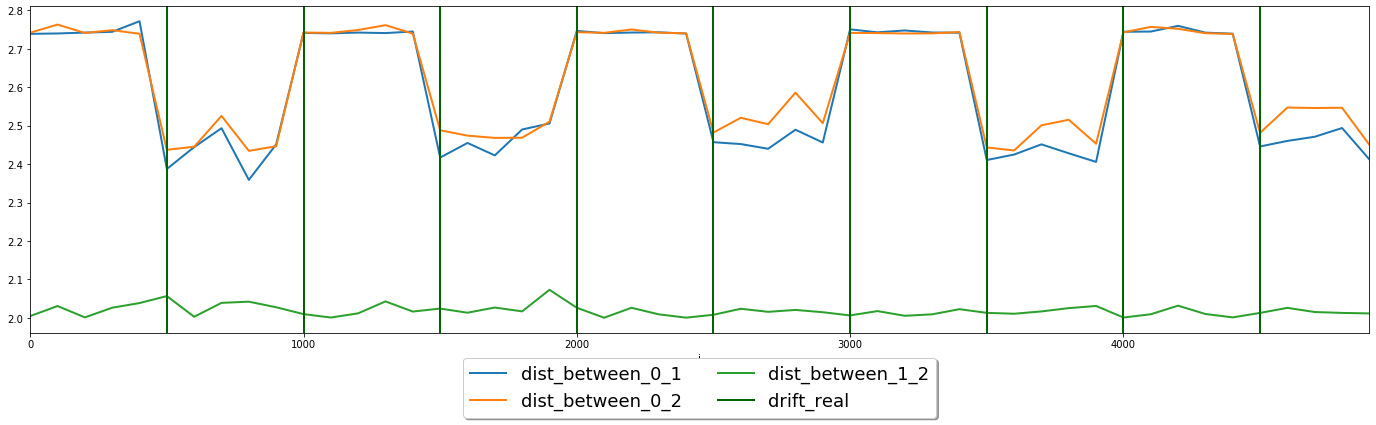

In [16]:
all_metrics[[
    col for col in all_metrics.columns if "dist_between_" in col and "diff" not in col and "avg" not in col
]].plot(figsize=(24,6), lw=2)

plts.plot_drift_vertical_lines(5000)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2, fontsize=18)

### OSTOVAR

In [127]:
prefix = r'C:/Users/rafae/Downloads/CPN_Logs_Characterization_Ext_/FragmentChange/'
logs_ostovar = glob.glob(prefix + r'Size1\*\*\*\*')

In [203]:
log_ = logs_ostovar[0]
all_metrics_kmeans = run_pipeline({
    "log": log_,
    "representation": "binary",
    "sliding_window": False,
    "window_size": 50,
    "model": 'kmeans__k=8'
    #"model": 'optics__min_samples=10_max_eps=10_metric=jaccard'
})

all_metrics_kmeans.index = all_metrics_kmeans.index + all_metrics_kmeans.index[0]

In [225]:
args = {
    "detection_type": 'mean', # "mean", #, "cumulative"],
    "representation": "binary",
    "model": "kmeans__k=8",
    "tipo_mudanca": "Conditiona",
    "log_size": 3000,
    "window_size": 50,
    "rolling_window": 3,
    "min_tol": 0.01,
    "std_tolerance": 1.0,
    "cols": ["avg_dist_between_centroids"],
    #"smooth_factor": 0.7
}

results_ostovar = drift_detect_pipeline(args, all_metrics_kmeans)

{'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0, 'Delay': 60.0, 'Correct_Predictions': [1, 1], 'Support': 2, 'Drifts_Found': [950, 1950], 'Resp': [890, 1890]}


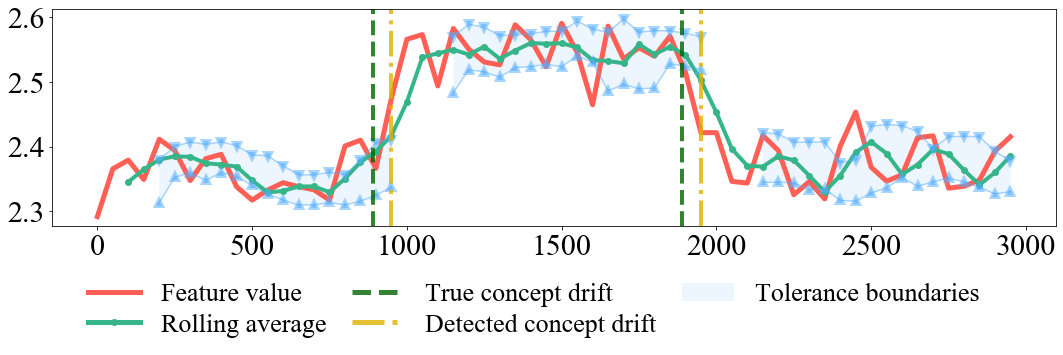

In [226]:
col = "avg_dist_between_centroids"

y_true = [890, 1890]
res = results_ostovar[(results_ostovar.measure == col) & (results_ostovar.log_size == args["log_size"])]

plts.plot_deteccao_drift(
    all_metrics_kmeans.rename(columns={col: "Feature value"}),
    'Feature value',
    [x for x in res.Drifts_Found.iloc[0]],
    y_true,
    res.extra.iloc[0]['means'],
    res.extra.iloc[0]['lowers'],
    res.extra.iloc[0]['uppers'],
    cluster_window_size=args['window_size'],
    save_png=""
)

# plt.gca().set_xlim((0, len(all_metrics_kmeans)))
# plt.xticks(np.arange(0, len(all_metrics_kmeans), 500));
plt.yticks(np.arange(2.3, 2.6, .1));

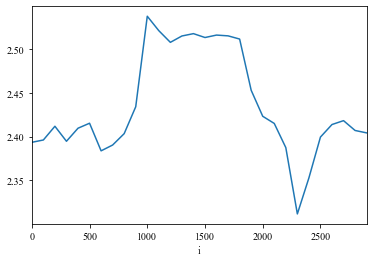

In [140]:
all_metrics_kmeans["avg_dist_between_centroids"].plot()